## Title
What do I do in this notebook

In [484]:
import pandas as pd
import numpy as np

In [485]:
df = pd.read_csv('data/nyc_bike_accidents.csv')
pd.options.display.max_columns = 50

In [486]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

df['YEAR'] = df['CRASH DATE'].dt.strftime('%Y')

In [487]:
df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
df

nyc_bike_accidents_2018_2022 = df[df['YEAR'].str.contains('2018|2019|2020|2021|2022')]
nyc_bike_accidents_2018_2022 = nyc_bike_accidents_2018_2022[['YEAR','LATITUDE', 'LONGITUDE','NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]

# And create new columns that will be used for visualization
nyc_bike_accidents_2018_2022['ACCIDENT TYPE'] = 0

nyc_bike_accidents_2018_2022.loc[nyc_bike_accidents_2018_2022['NUMBER OF CYCLIST INJURED'] > 0, 'ACCIDENT TYPE'] = 'Injured'
nyc_bike_accidents_2018_2022.loc[nyc_bike_accidents_2018_2022['NUMBER OF CYCLIST KILLED'] > 0, 'ACCIDENT TYPE'] = 'Fatal'

nyc_bike_accidents_2018_2022

,YEAR,LATITUDE,LONGITUDE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,ACCIDENT TYPE
0,2021,40.687534,-73.977500,1,0,Injured
1,2021,40.784615,-73.953964,1,0,Injured
2,2022,40.767242,-73.986206,1,0,Injured
3,2021,40.592070,-73.962990,1,0,Injured
4,2021,40.640835,-73.989670,1,0,Injured
...,...,...,...,...,...,...
49439,2022,40.697758,-73.793330,1,0,Injured
49441,2022,40.629870,-73.977005,1,0,Injured
49494,2022,40.748245,-73.976295,1,0,Injured
49499,2022,40.812430,-73.903130,1,0,Injured


In [488]:
nyc_bike_accidents_2018_2022.to_csv('data/nyc_bike_accidents_2018_2022.csv', index=False)

### Reasons for accidents

In [489]:
bike_df = df.groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().sort_values('NUMBER OF PERSONS INJURED', ascending=False).reset_index()
bike_df = bike_df[['CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]

# Drop the first row, because that is the cases where the reason was unspecified.
bike_df.drop(index=0, inplace=True)

# Get top 10 reasons
bike_df = bike_df.head(10)

In [490]:
bike_df.to_csv('data/nyc_accidents_reason.csv')

In [491]:
#bike_df_2022 = df[df['YEAR'] == '2022']
bike_df = df

#Standardize the vehicle types
bike_df.replace(['E-Bike', 'BICYCLE', 'E-Bik'], 'Bike')

# Create a column that specifies if the vehicle type was a bike or not.
bike_df['vehicle_1_bike'] = np.where(bike_df['VEHICLE TYPE CODE 1'] == 'Bike', 0, 1)

# Group by the vehicle type and the reason for the accident.
bike_df = bike_df.groupby(['vehicle_1_bike','CONTRIBUTING FACTOR VEHICLE 1']).sum().sort_values('NUMBER OF PERSONS INJURED', ascending=False).reset_index()
bike_df = bike_df[['CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'vehicle_1_bike']]

# Drop the rows where the reason was unspecified.
bike_df = bike_df[bike_df["CONTRIBUTING FACTOR VEHICLE 1"].str.contains("Unspecified") == False]

In [492]:
bike_df_5 = bike_df.head(5)

In [493]:
bike_df_5.to_csv('data/nyc_accidents_reason_5.csv')

### Prepare accident data for mapping

In this section of the notebook I prepare the accident data to be mapped as dots on a datawrapper map. For the mapping I need information about the location of the accident, whether the cyclist was injured or killed (to color the dots depending on it).

In [494]:
df.groupby('YEAR').sum('NUMBER OF PERSONS KILLED')

,Unnamed: 0,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,COLLISION_ID,vehicle_1_bike
YEAR,,,,,,,,,,
2012,3789847104,21810871.0,82042.521399,-148985.590667,2058.0,6.0,2021,6,302982984,2015
2013,6374228922,40091890.0,151193.640470,-274536.520564,3768.0,8.0,3725,8,525814550,3713
2014,5550244111,39608844.0,149907.740100,-272167.003660,3729.0,16.0,3681,16,3865115452,3680
2015,5006430481,41577236.0,157682.844458,-286286.717771,3935.0,15.0,3884,15,12653422642,3871
2016,4571252281,35119336.0,173723.351518,-315427.251408,4401.0,13.0,4308,13,15020782782,3306
2017,3860317004,35140875.0,185856.188187,-337464.337220,4660.0,31.0,4580,24,16968539230,3050
2018,2716060279,35684611.0,180279.764749,-327330.195093,4575.0,9.0,4460,9,17484041614,2742
2019,1835687992,37791538.0,191075.813372,-346917.387261,4789.0,29.0,4714,29,19584532445,3686
2020,1170515404,42011082.0,210935.405135,-382899.818754,5374.0,25.0,5276,24,22498290869,4195


In [495]:
# Get only the data from 2022
df_2022 = df[df['YEAR'] == '2022']

# Get only the columns we need
df_2022 = df_2022[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF CYCLIST INJURED', 'ON STREET NAME', 'CROSS STREET NAME']]

# And create new columns that will be used for visualization
df_2022['ACCIDENT TYPE'] = 0

df_2022.loc[df_2022['NUMBER OF CYCLIST INJURED'] > 0, 'ACCIDENT TYPE'] = 'Injured'
df_2022.loc[df_2022['NUMBER OF CYCLIST KILLED'] > 0, 'ACCIDENT TYPE'] = 'Fatal'

df_2022['INJURED OR DEATH'] = df_2022['NUMBER OF CYCLIST KILLED'] + df_2022['NUMBER OF CYCLIST INJURED']

df_2022.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

In [496]:
df_2022.to_csv('data/nyc_bike_crashes_2022.csv')

And to check if any streets are particularly dangerous for cyclists.

In [497]:
df_2022.groupby('ON STREET NAME').sum().sort_values('INJURED OR DEATH', ascending=False).head(50)

,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF CYCLIST KILLED,NUMBER OF CYCLIST INJURED,INJURED OR DEATH
ON STREET NAME,,,,,,
BROADWAY,574128.0,3546.749792,-6432.960127,0,90,90
4 AVENUE,659666.0,2846.366428,-5179.957104,0,71,71
3 AVENUE,375181.0,2119.210039,-3845.993052,0,54,54
BEDFORD AVENUE,246820.0,1911.458332,-3475.896218,0,48,48
2 AVENUE,363463.0,1711.774058,-3106.570754,1,43,44
5 AVENUE,282135.0,1750.510665,-3181.335502,0,43,43
1 AVENUE,200441.0,1385.812630,-2514.717171,0,37,37
8 AVENUE,260243.0,1385.647392,-2515.101474,0,34,34
7 AVENUE,187526.0,1222.081275,-2219.443542,0,30,30


### Development of accidents over time

In [498]:
accidents = pd.read_csv('data/nyc_bike_accidents.csv')

bikers = pd.read_csv('data/nyc_bikerides_numbers.csv')

In [499]:
accidents['CRASH DATE'] = pd.to_datetime(accidents['CRASH DATE'])

accidents['YEAR'] = accidents['CRASH DATE'].dt.strftime('%Y')

accidents_year = accidents.groupby('YEAR').sum('NUMBER OF PERSONS KILLED')
accidents_year = accidents_year[['NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
accidents_year

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
YEAR,,
2012,2210,6
2013,4075,11
2014,4000,20
2015,4281,15
2016,4975,18
2017,4889,27
2018,4725,10
2019,4986,31
2020,5576,29


In [500]:
accidents_year = accidents_year.reset_index()

accidents_year.rename(columns={"YEAR": "year", "NUMBER OF CYCLIST INJURED": "injured", "NUMBER OF CYCLIST KILLED": "killed"}, inplace=True)


In [501]:
bikers['year'] = bikers['Unnamed: 0']
bikers = bikers[['year', 'Total Daily Cycling Trips']]

In [502]:
bikers.drop([13], inplace=True)

In [503]:
bikers_accidents = pd.merge(accidents_year, bikers, on=['year'], how='left')


# Standardize the injuries and deaths per 1 million rides
bikers_accidents['injury_rate'] = bikers_accidents['injured'] / (bikers_accidents['Total Daily Cycling Trips'] * 365) * 1000000
bikers_accidents['fatality_rate'] = bikers_accidents['killed'] / (bikers_accidents['Total Daily Cycling Trips'] * 365) * 1000000

bikers_accidents.rename({'Total Daily Cycling Trips': 'total_daily_bikerides'}, axis=1, inplace=True)

In [504]:
bikers_accidents_rates = bikers_accidents[['year', 'injury_rate', 'fatality_rate']]

In [505]:
bikers_accidents_rates.to_csv('data/nyc_accidents_development_2012_2021.csv', index=False)

In [506]:
bikers_injuries = bikers_accidents[['year', 'injured']]
bikers_injuries.to_csv('data/nyc_injuries_development_2012_2021.csv', index=False)

In [507]:
bikers_accidents

,year,injured,killed,total_daily_bikerides,injury_rate,fatality_rate
0,2012,2210,6,320000.0,18.921233,0.051370
1,2013,4075,11,380000.0,29.379957,0.079308
2,2014,4000,20,420000.0,26.092629,0.130463
3,2015,4281,15,450000.0,26.063927,0.091324
4,2016,4975,18,460000.0,29.630733,0.107207
5,2017,4889,27,490000.0,27.335756,0.150964
6,2018,4725,10,510000.0,25.382756,0.053720
7,2019,4986,31,530000.0,25.774102,0.160248
8,2020,5576,29,NaN,NaN,NaN
9,2021,4961,19,550000.0,24.712329,0.094645


In [508]:
melt = pd.melt(bikers_accidents, id_vars=['year'], value_vars=['injury_rate', 'fatality_rate'], var_name='accident_type', value_name='rate')
melt = melt[melt['rate'].notna()]
melt['year'] = melt['year'].astype(int)

melt.to_csv('data/nyc_accidents_development_2012_2021_long.csv.csv', index=False)

In [509]:
melt.to_csv('data/nyc_accidents_development_2012_2021_long.csv.csv', index=False)

In [510]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [511]:
%%R

require('ggplot2')
require('readr')
require('extrafont')
require('dplyr')
require('reshape2')
require('tidyverse')

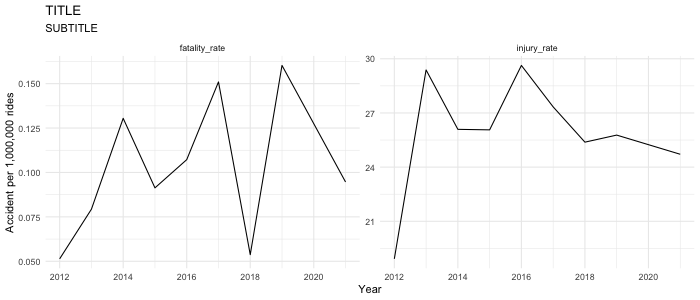

In [512]:
%%R -i melt -w 700 -h 300

ggplot(melt, aes(x=year, y=rate)) +
  geom_line() +
  facet_wrap(~accident_type, scales='free_y', ncol=2) +
  theme_minimal()+
    labs(
    x = 'Year',
    y = 'Accident per 1,000,000 rides',
    title = 'TITLE',
    subtitle = 'SUBTITLE',
    )